In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-31_11-32_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.16435520596149866

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
GC       0.25
NQ       0.25
YM       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    13763.0
GC    -1501.8
NQ    26350.6
YM    22806.6
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

61418.399999999994

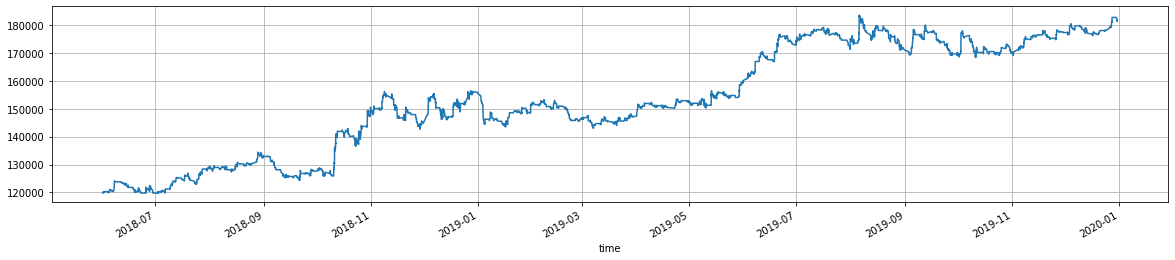

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     721
 GC    1291
 NQ    2114
 YM     705
 Name: action, dtype: int64,
 4831)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.750000
 GC    3.133495
 NQ    5.131068
 YM    1.711165
 Name: action, dtype: float64,
 11.725728155339805)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1514.10
GC    3124.22
NQ    4439.40
YM    1480.50
Name: commission, dtype: float64

In [16]:
df.commission.sum()

10558.220000000001

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.37,-2.33,426.70,-256.57,1.66,-3.76,645.0
NQ,0.40,24.93,442.06,-250.10,1.77,26.76,1057.0
ES,0.41,38.23,805.75,-491.47,1.64,40.39,360.0
YM,0.40,64.79,715.30,-364.79,1.96,67.25,352.0
total,0.39,25.44,535.02,-303.51,1.76,23.52,2414.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,0.083070,0.252420,0.494741,0.771024
GC,0.083070,1.000000,0.051960,0.099341,0.399183
NQ,0.252420,0.051960,1.000000,0.215232,0.621582
YM,0.494741,0.099341,0.215232,1.000000,0.722303
total,0.771024,0.399183,0.621582,0.722303,1.000000


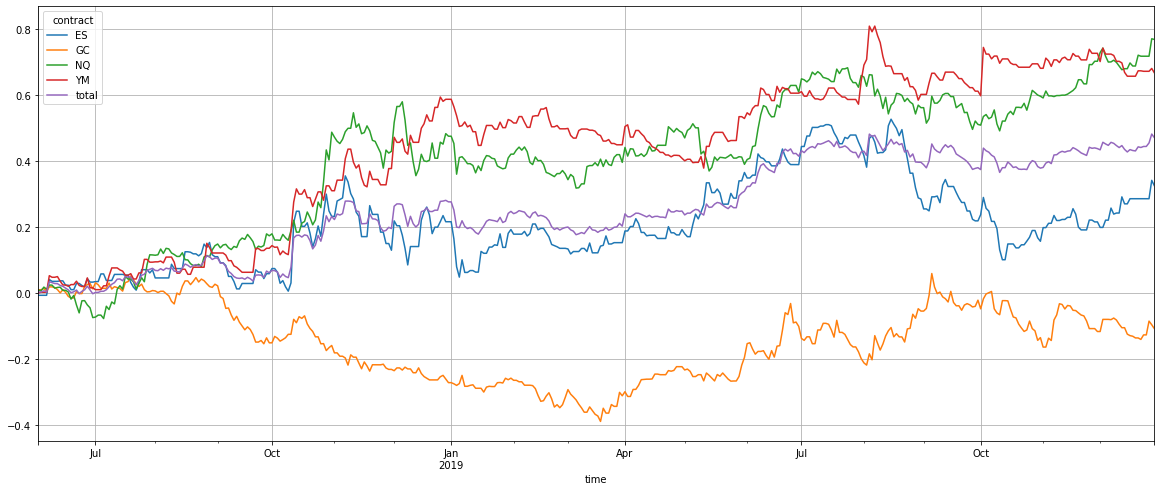

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

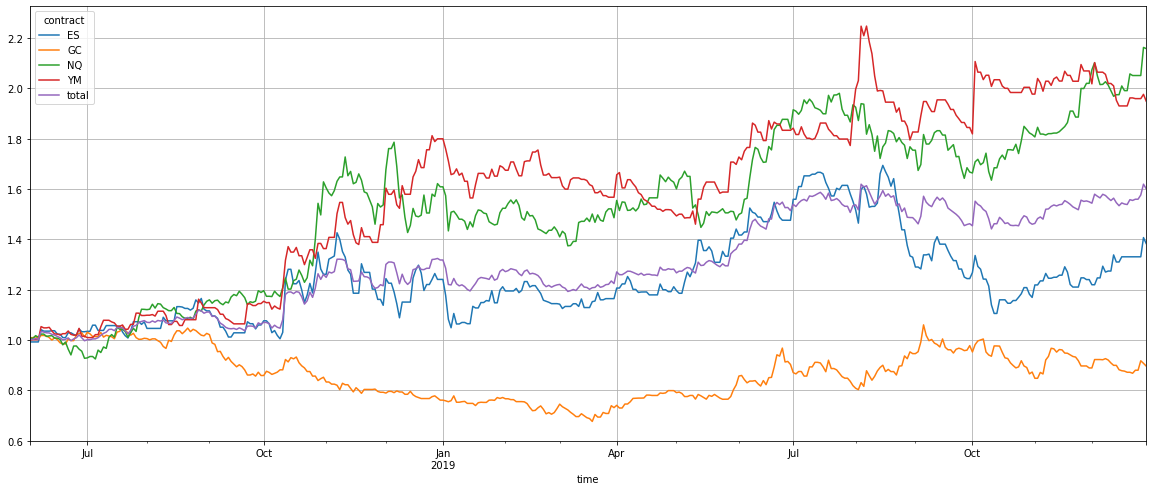

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.219646,-0.064427,0.600609,0.504083,0.333667
Cumulative returns,0.383520,-0.103161,1.157695,0.949061,0.601188
Annual volatility,0.410983,0.269884,0.366340,0.342203,0.225530
Sharpe ratio,0.682765,-0.113453,1.466522,1.358808,1.388085
Calmar ratio,0.632727,-0.180457,2.606224,2.503866,3.041621
Stability,0.417918,0.014147,0.808609,0.850558,0.875934
Max drawdown,-0.347142,-0.357019,-0.230452,-0.201322,-0.109700
Omega ratio,1.154296,0.979685,1.312076,1.361436,1.308911
Sortino ratio,1.199292,-0.184087,2.402156,2.905124,2.604234
Skew,1.721067,0.954188,0.455222,2.375551,1.693648


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,3.33,1.24,-7.22,1.55,-0.25
2018-07-31,3.80,-0.51,20.95,8.10,8.02
2018-08-31,4.06,1.93,2.84,2.82,3.15
2018-09-30,-5.02,-16.29,3.04,1.45,-4.36
2018-10-31,18.99,-0.80,36.94,19.07,18.63
2018-11-30,-9.76,-7.00,-5.63,6.96,-3.59
2018-12-31,9.03,-3.94,4.69,23.39,8.43
2019-01-31,-2.34,1.37,-5.30,-6.28,-2.85
2019-02-28,-5.54,-5.70,-5.83,-2.45,-4.79


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        38.0
GC       -10.0
NQ       116.0
YM        95.0
total     60.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:26:30,YM,BUY,26046.00,4740.80
2018-10-11 04:23:00,ES,BUY,2766.50,4245.80
2019-08-05 21:19:00,YM,BUY,25615.00,3190.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
2018-12-03 15:44:00,YM,SELL,25969.00,2985.80
...,...,...,...,...
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20
2018-12-07 14:41:30,ES,BUY,2698.00,-1354.20
2018-12-21 00:01:30,ES,BUY,2488.75,-1391.70


In [26]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2018-10-11,0.201107,0.046527,0.031493,0.092773,0.092975
2018-12-03,0.093193,-0.003989,0.091247,0.099527,0.069994
2019-10-02,0.053610,0.030688,0.026633,0.158027,0.067239
2019-08-05,0.091387,0.034849,0.035793,0.106360,0.067097
2019-09-05,0.043610,0.068677,0.070387,0.030053,0.053182
...,...,...,...,...,...
2019-10-10,-0.061947,-0.005323,-0.020533,-0.021613,-0.027354
2018-12-07,-0.039030,0.008839,-0.053647,-0.036447,-0.030071
2018-12-10,-0.049170,-0.005323,-0.074313,-0.009087,-0.034473
